In [50]:
import re
import requests

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup

### Task 1. Predict the performance of top 1 supercomputer in 2025.
На основании данных рейтинга top500 спрогнозировать  производительность компьютера №1 в 2025


In [58]:
# parse data
URL = "https://www.top500.org/statistics/perfdevel/"

response = requests.get(URL)
soup = BeautifulSoup(response.text, 'html.parser')
text = soup.findAll('script', {"type" : "text/javascript"})[9].text

unit_mapping = {
    'GFlop/s': 1e9,
    'TFlop/s': 1e12,
    'PFlop/s': 1e15,
    'EFlop/s': 1e18,
}

dates = [x[1] for x in re.findall('("(\d{2}\/\d{4}): #1)', text)]
years = [int(x.split('/')[1]) for x in dates]
months = [int(x.split('/')[0]) for x in dates]
n1_flops = [float(x[0]) * unit_mapping[x[1]]
            for x in re.findall('#1 = (\d+\.\d+) (\w+\/s)', text)]
n500_flops = [float(x[0]) * unit_mapping[x[1]]
              for x in re.findall('#500 = (\d+\.\d+) (\w+\/s)', text)]

df = pd.DataFrame({'year': years,
                   'month': months,
                   'n1': n1_flops,
                   'n500': n500_flops})

start_year = df.year.min()
start_month = df[df.year == start_year].month.min()
df['total_month'] = 12 * (df.year - start_year) + df.month - start_month

df.tail()

,year,month,n1,n500,total_month
54,2020,6,4.155000e+17,1.200000e+15,324
55,2020,11,4.420000e+17,1.300000e+15,329
56,2021,6,4.420000e+17,1.500000e+15,336
57,2021,11,4.420000e+17,1.600000e+15,341
58,2022,6,1.100000e+18,1.600000e+15,348


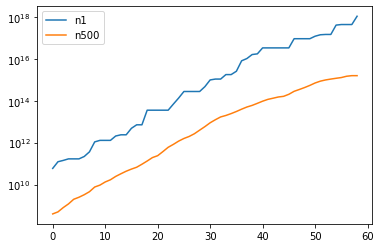

In [59]:
df[['n1', 'n500']].plot(logy = True);

In [62]:
X = np.array(df.total_month).reshape(-1,1)
y_log_n1 = np.log(df.n1)
y_log_n500 = np.log(df.n500)

In [63]:
lin_reg_n1 = LinearRegression().fit(X, y_log_n1)
lin_reg_n500 = LinearRegression().fit(X, y_log_n500)

In [64]:
years_to_pred = 3

X_test = X[-1:] + np.arange(12 * years_to_pred).reshape(-1, 1)

In [65]:
y_pred_n1 = np.exp(lin_reg_n1.predict(X_test))
y_pred_n500 = np.exp(lin_reg_n500.predict(X_test))

In [128]:
months = (np.r_[X, X_test])
months += start_month
years = np.concatenate(months // 12 + start_year)
months = np.concatenate(months % 12)

y_EFlops_n1 = np.r_[np.array(df.n1), y_pred_n1] / unit_mapping['EFlop/s']
y_EFlops_n500 = np.r_[np.array(df.n500), y_pred_n500] / unit_mapping['EFlop/s']
y_GFlops_n1 = np.r_[np.array(df.n1), y_pred_n1] / unit_mapping['GFlop/s']
y_GFlops_n500 = np.r_[np.array(df.n500), y_pred_n500] / unit_mapping['GFlop/s']
y_PFlops_n500 = np.r_[np.array(df.n500), y_pred_n500] / unit_mapping['PFlop/s']
df_final = pd.DataFrame({'year': years,
               'month': months,
               'n1': np.r_[np.array(df.n1), y_pred_n1],
               'n500': np.r_[np.array(df.n500), y_pred_n500]})
df_final.tail()

,year,month,n1,n500
90,2025,1,8.892326e+18,3.231935e+16
91,2025,2,9.336449e+18,3.382492e+16
92,2025,3,9.802753e+18,3.540063e+16
93,2025,4,1.029235e+19,3.704974e+16
94,2025,5,1.080639e+19,3.877567e+16


In [93]:
print(f"Top 1 in 2025 {y_EFlops_n1[-1]:.2f} EFlops")
print(f"Top 500 in 2025 {y_EFlops_n500[-1]:.2f} EFlops")
print(f"Top 500 in 2025 {y_PFlops_n500[-1]:.2f} PFlops")

Top 1 in 2025 10.81 EFlops
Top 500 in 2025 0.04 EFlops
Top 500 in 2025 38.78 PFlops


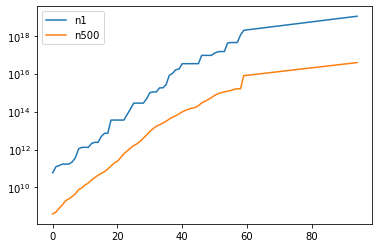

In [94]:
df_final[['n1', 'n500']].plot(logy = True);

### Task 2. Find the percentage of all consumption on Earth consumed by all computers from the top500
Оцените какой процент всего производимого на Земле электричества потребляют все компьютеры из top500 (на основании открытых данных top500.org)

Total world electricity consumption in 2021 $28466.3$ $TWh$ $=$ $10^9$ $kWh$

Source [Statistical Review of World Energy 2022](https://www.bp.com/content/dam/bp/business-sites/en/global/corporate/pdfs/energy-economics/statistical-review/bp-stats-review-2022-full-report.pdf)


In [138]:
URL = 'https://www.top500.org/lists/top500/list/2022/06/?page='

window_len = 3
power_consumption_kwh = 0
power_consumption_kwh_approximate = list()
response = requests.get(URL + '1')
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
# table
for x in table.findAll('td')[5::6]:
    value = x.text
    if value:
        try:
            power_kwh = float(value.replace(',', ''))
            power_consumption_kwh += power_kwh
            power_consumption_kwh_approximate.append(power_kwh)
        except:
            continue
    else:
        # To fix none values fill them with mean of window_len last values
        power_consumption_kwh_approximate.append(
            sum(power_consumption_kwh_approximate[-window_len:])/window_len)


print(f'Top-500 total power consumption: {power_consumption_kwh:.1f} kWh.')
print(f'Top-500 total approximate power consumption: {sum(power_consumption_kwh_approximate):.1f} kWh.')
total_world_power_production_kwh = 28466.3 * 1e9
print(f'Result {power_consumption_kwh / total_world_power_production_kwh * 100:.9f}%')
print(f'Approximate result  {sum(power_consumption_kwh_approximate) / total_world_power_production_kwh * 100:.9f}%')

Top-500 total power consumption: 195516.0 kWh.
Top-500 total approximate power consumption: 269296.0 kWh.
Result 0.000000687%
Approximate result  0.000000946%
